Answer all questions and submit them either as an IPython notebook, LaTeX document, or Markdown document. Provide full answers for each question, including interpretation of the results. Each question is worth 25 points.

## Question 1

The goal of this problem is to investigate the role of the proposal distribution in a Metropolis-Hastings algorithm designed to simulate from the posterior distribution of the mixture parameter $\delta$. 

1. Simulate 200 realizations from the mixture distribution:
    $$y_i \sim \delta N(7, 0.5^2) + (1-\delta) N(10, 0.5^2)$$
    with $\delta = 0.7$. Plot a histogram of these data. 
2. Implement an ABC procedure to simulate from the posterior distribution of $\delta$, using your data from part (1). 
3. Implement a random walk M-H algorithm with proposal $\delta^{\prime} = \delta^{(i)} + \epsilon$ with $\epsilon \sim Unif(−1,1)$. 
4. Reparameterize the problem letting $U = \log\left[\frac{\delta}{1 - \delta}\right]$ and $u^{\prime} = u^{(i)} + \epsilon$. Implement a random walk chain in U-space. 
5. Compare the estimates and convergence behavior of the three algorithms.

In part (1), you are asked to simulate data from a distribution with $\delta$ known. For parts (2)–(4), assume $\delta$ is unknown with prior $\delta \sim Unif( 0,1)$. For parts (2)–(4), provide an appropriate plot and a table summarizing the output of the algorithm. To facilitate comparisons, use the same number of iterations, random seed, starting values, and burn-in period for all implementations of the algorithm. 

 [-----------------100%-----------------] 200 of 200 complete in 0.1 secPlotting y


C:\Users\Andrew Plassard\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


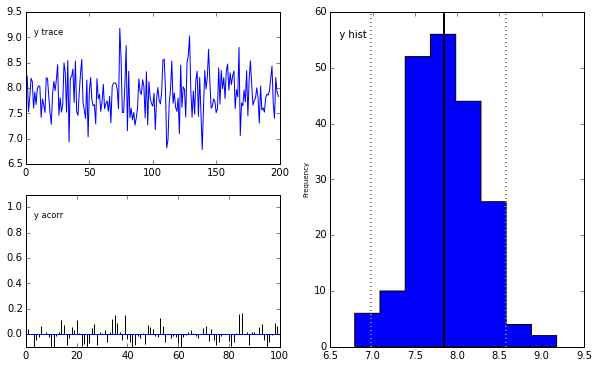

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import pymc as pm

def mixture_distribution(delta=0.7):
    mu1 = pm.Normal('mu1',7.,1./(.5**2))
    mu2 = pm.Normal('mu2',10,1./(.5**2))
    @pm.deterministic
    def y(mu1=mu1,mu2=mu2,delta=delta):
        return (delta*mu1) + (1-delta)*mu2
    
    return locals()

dist = pm.MCMC(mixture_distribution())
dist.sample(200)
pm.Matplot.plot(dist.y)

We see a little bit of autocorrelation in this model, but that's not unexpected due to the simplicity of the model. 

In [18]:
'''Implement an ABC procedure to simulate values from the posterior delta'''
import numpy as np
import scipy.stats
dist = pm.MCMC(mixture_distribution())
dist.sample(200)
target = dist.y.trace()

eps = .05
accept = lambda a,b: (scipy.stats.ttest_ind(a,b)[1] > eps)

N = 50
trace = []
K = 0
while(len(trace) < N):
    K += 1
    d = np.random.uniform()
    dist = pm.MCMC(mixture_distribution(d))
    dist.sample(200)
    sample = dist.y.trace()
    a = accept(sample,target)
    if a:
        trace.append(sample)
print()
print('This took %d iterations' % K)

 [-----------------100%-----------------] 200 of 200 complete in 0.1 sec
This took 1046 iterations


That took a lot of iterations and its not clear if it really worked well.

In [6]:
import numpy as np
import scipy.stats

N = 50

dist = pm.MCMC(mixture_distribution())
dist.sample(200)

target = dist.y.trace()
get_p = lambda x,y: scipy.stats.ttest_ind(x,y)[1]

d = np.random.uniform()
dist = pm.MCMC(mixture_distribution(d))
dist.sample(200)
sample = dist.y.trace()
prev_d = d

prev_p = get_p(sample,target)

trace = []
K = 0
while(len(trace) < N):
    K += 1
    d = np.random.uniform()
    d = (d-.5)*2.
    d = prev_d + d
    dist = pm.MCMC(mixture_distribution(d))
    dist.sample(200)
    sample = dist.y.trace()
    p = get_p(sample,target)
    if p > 0.05:
        trace.append(sample)
    if p > prev_p or np.random.uniform() > (1-p):
        prev_p = p
        prev_d = d
print()
print('This took %s iterations' % K)

 [-----------------100%-----------------] 200 of 200 complete in 0.1 sec
This took 2077 iterations


In [16]:
import numpy as np
import scipy.stats
import math

N = 50

dist = pm.MCMC(mixture_distribution())
dist.sample(200)

target = dist.y.trace()
get_p = lambda x,y: scipy.stats.ttest_ind(x,y)[1]

u = np.random.uniform()
d = math.exp(u)/(1+math.exp(u))
dist = pm.MCMC(mixture_distribution(d))
dist.sample(200)
sample = dist.y.trace()
prev_u = u

prev_p = get_p(sample,target)

trace = []
K = 0
while(len(trace) < N):
    K += 1
    u = np.random.uniform()
    u = (u-.5)*2.
    u = prev_u + u
    d = math.exp(u)/(1+math.exp(u))
    dist = pm.MCMC(mixture_distribution(d))
    dist.sample(200)
    sample = dist.y.trace()
    p = get_p(sample,target)
    if p > 0.05:
        trace.append(sample)
    if p > prev_p or np.random.uniform() > (1-p):
        prev_p = p
        prev_u = u
print()
print('This took %s iterations' % K)

 [-----------------100%-----------------] 200 of 200 complete in 0.1 sec
This took 434 iterations


The third procedure worked best. This is most likely because the step function works in the space closest to the change in distribution of interest for this function (i.e. 0-1).

## Question 2

Carlin (1992) considers a Bayesian approach to meta-analysis, and includes the following examples of 22 trials of beta-blockers to prevent mortality after myocardial infarction. These data are given below.

In one possible random effects model we assume the true baseline mean (on a log-odds scale) $\mu_i$ in a trial $i$
is drawn from some population distribution. Let $r^C_i$ denote number of events in the control group in trial $i$, and $r^T_i$ denote events under active treatment in trial $i$. Our model is:

$$\begin{aligned}
r^C_i &\sim \text{Binomial}\left(p^C_i, n^C_i\right) \\
r^T_i &\sim \text{Binomial}\left(p^T_i, n^T_i\right) \\
\text{logit}\left(p^C_i\right) &= \mu_i \\
\text{logit}\left(p^T_i\right) &= \mu_i + \delta \\
\mu_i &\sim \text{Normal}(m, s).
\end{aligned}$$

In this case, we want to make inferences about the population effect $m$, and the predictive distribution for the effect $\mu_{\text{new}}$ in a new trial. 

This particular model uses a random effect for the population mean, and a fixed effect for the treatment effect. There are 3 other models you could fit to represent all possible combinations of fixed or random effects for these two parameters.

Build all 4 models to estimate the treatment effect in PyMC and 

1. use convergence diagnostics to check for convergence in each model 
2. use posterior predictive checks to compare the fit of the models
3. use DIC to compare the models as approximations of the true generating model

Which model would you select and why?

In [8]:
r_t_obs = [3, 7, 5, 102, 28, 4, 98, 60, 25, 138, 64, 45, 9, 57, 25, 33, 28, 8, 6, 32, 27, 22]
n_t_obs = [38, 114, 69, 1533, 355, 59, 945, 632, 278,1916, 873, 263, 291, 858, 154, 207, 251, 151, 174, 209, 391, 680]
r_c_obs = [3, 14, 11, 127, 27, 6, 152, 48, 37, 188, 52, 47, 16, 45, 31, 38, 12, 6, 3, 40, 43, 39]
n_c_obs = [39, 116, 93, 1520, 365, 52, 939, 471, 282, 1921, 583, 266, 293, 883, 147, 213, 122, 154, 134, 218, 364, 674]
N = len(n_c_obs)

In [9]:
%matplotlib inline
import pymc as pm

# Random effect for population, fixed effect for treatment
def meta_analysis1():
    
    m = pm.Uniform('m', -100, 100, value=0)
    s = pm.Uniform('s', 0, 10, value=1 )
    mu = pm.Normal('mu', m, s, value=1, observed=False)
    
    delta = pm.Uniform('delta', -100, 100, value=0, observed=False)
    
    @pm.deterministic
    def pc(mu=mu):
        return pm.invlogit(mu)
    rc = pm.Binomial('rc', n=n_c_obs, value=r_c_obs, p=pc,observed=True)
    
    @pm.deterministic
    def pt(mu=mu, delta=delta):
        return pm.invlogit(mu+delta)
    rt = pm.Binomial('rt', n=n_t_obs, value=r_t_obs, p=pt, observed=True)
    
    
    
    return locals()

# Random effect for population, random effect for treatment
def meta_analysis2():
    
    m = pm.Uniform('m', -100, 100, value=0)
    s = pm.Uniform('s', 0, 10, value=1 )
    mu = pm.Normal('mu', m, s, value=1, observed=False)
    
    m2 = pm.Uniform('m2', -100, 100, value=0)
    s2 = pm.Uniform('s2', 0, 10, value=1 )
    delta = pm.Normal('delta', m2, s2, value=1, observed=False)
    
    @pm.deterministic
    def pc(mu=mu):
        return pm.invlogit(mu)
    rc = pm.Binomial('rc', n=n_c_obs, value=r_c_obs, p=pc,observed=True)
    
    @pm.deterministic
    def pt(mu=mu, delta=delta):
        return pm.invlogit(mu+delta)
    rt = pm.Binomial('rt', n=n_t_obs, value=r_t_obs, p=pt, observed=True)
    
    return locals()

# Fixed effect for population, random effect for treatment
def meta_analysis3():
    
    mu = pm.Uniform('mu', -100, 100, value=1, observed=False)
    
    m = pm.Uniform('m', -100, 100, value=0)
    s = pm.Uniform('s', 0, 10, value=1 )
    delta = pm.Normal('delta', m, s, value=1, observed=False)
    
    @pm.deterministic
    def pc(mu=mu):
        return pm.invlogit(mu)
    rc = pm.Binomial('rc', n=n_c_obs, value=r_c_obs, p=pc,observed=True)
    
    @pm.deterministic
    def pt(mu=mu, delta=delta):
        return pm.invlogit(mu+delta)
    rt = pm.Binomial('rt', n=n_t_obs, value=r_t_obs, p=pt, observed=True)
    
    return locals()

# Fixed effect for population, fixed effect for treatment
def meta_analysis4():
    
    mu = pm.Uniform('mu', -100, 100, value=1, observed=False)
    
    delta = pm.Uniform('delta', -100, 100, value=1, observed=False)
    
    @pm.deterministic
    def pc(mu=mu):
        return pm.invlogit(mu)
    rc = pm.Binomial('rc', n=n_c_obs, value=r_c_obs, p=pc,observed=True)
    
    @pm.deterministic
    def pt(mu=mu, delta=delta):
        return pm.invlogit(mu+delta)
    rt = pm.Binomial('rt', n=n_t_obs, value=r_t_obs, p=pt, observed=True)
    
    return locals()

We defined four models here with the four possible combinations of fixed and random effects on population and local effects. These models were built based on varying the type of distribution of delta and mu and if they have priors.

 [-----------------100%-----------------] 100 of 100 complete in 0.1 sec

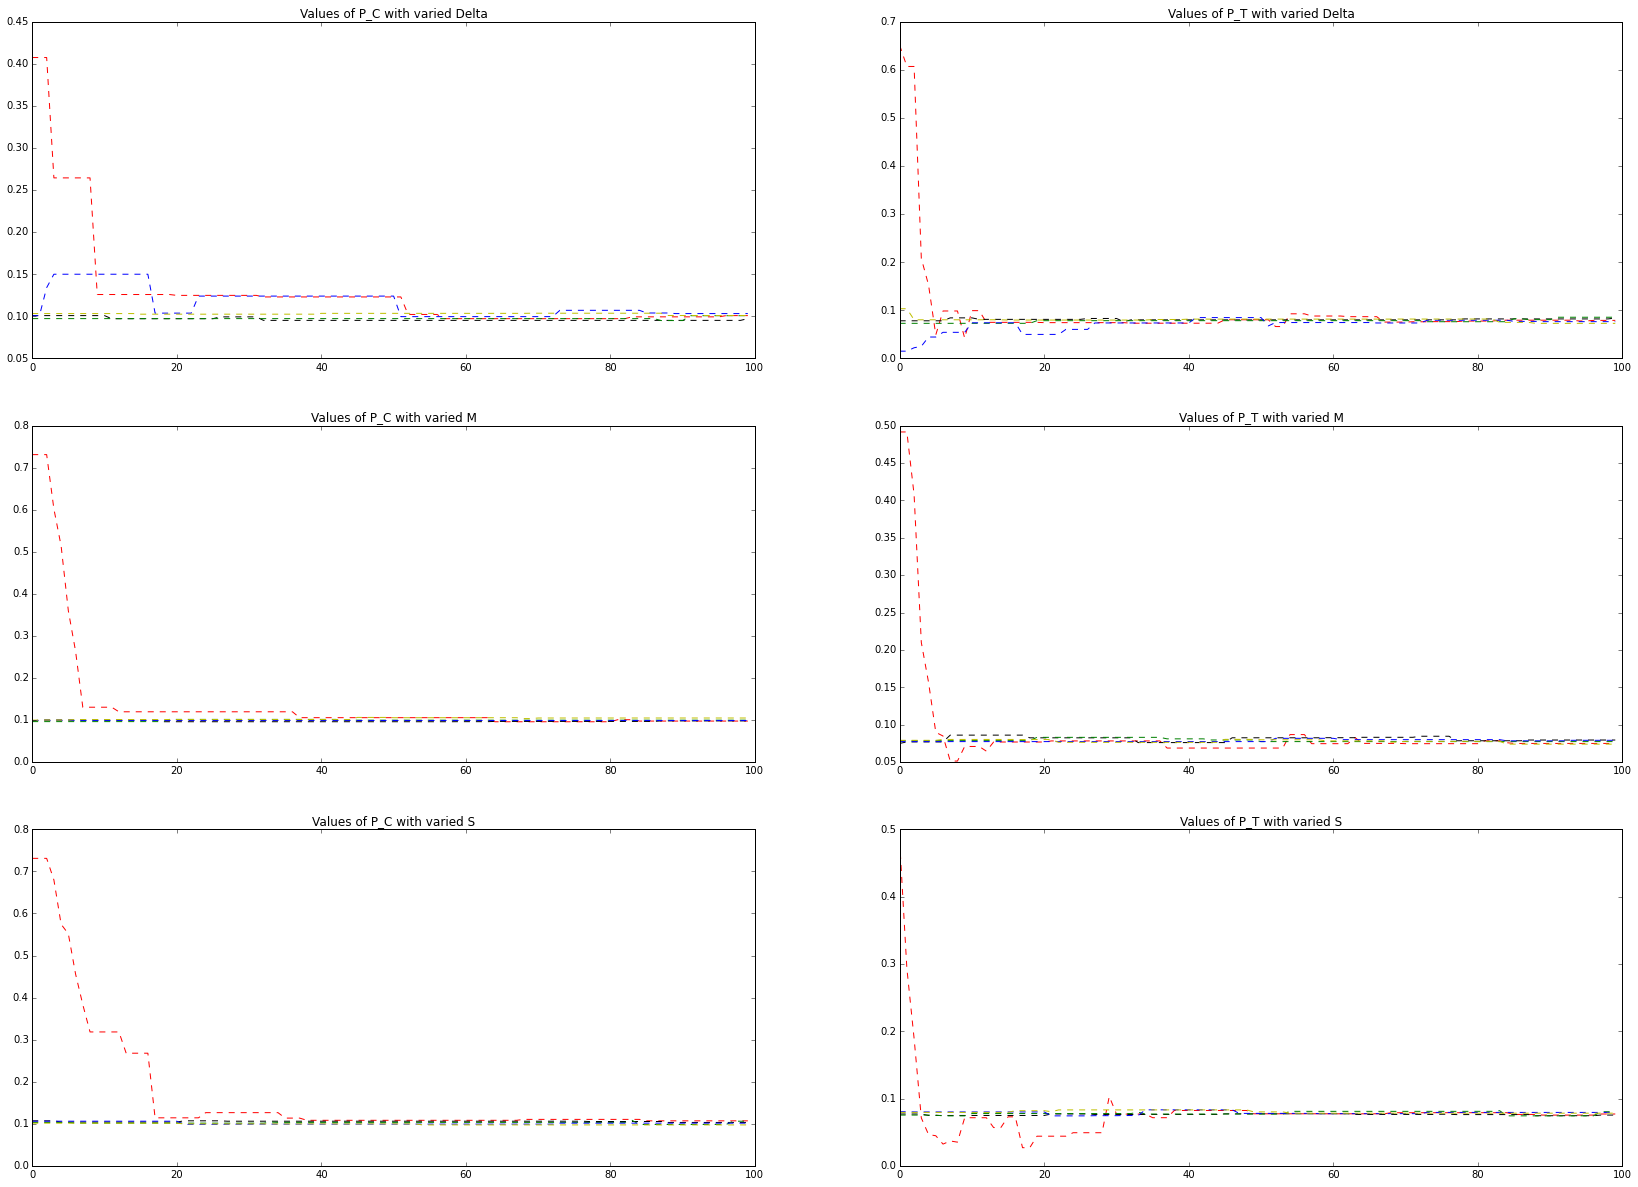

In [10]:
import matplotlib.pyplot as plt

num_samples = 100

fig, ax = plt.subplots()
fig.set_size_inches(28.5, 20.5)

meta = pm.MCMC(meta_analysis1())
meta.delta.set_value(1.)
meta.sample(num_samples)

meta.delta.set_value(2.)
meta.sample(num_samples)

meta.delta.set_value(-1.)
meta.sample(num_samples)

meta.delta.set_value(-2.)
meta.sample(num_samples)

meta.delta.set_value(0.)
meta.sample(num_samples)

plt.subplot(3,2,1)
plt.plot(meta.pc.trace(chain=0), 'r--')
plt.plot(meta.pc.trace(chain=1), 'k--')
plt.plot(meta.pc.trace(chain=2), 'g--')
plt.plot(meta.pc.trace(chain=3), 'b--')
plt.plot(meta.pc.trace(chain=4), 'y--')

plt.title('Values of P_C with varied Delta')


plt.subplot(3,2,2)
plt.plot(meta.pt.trace(chain=0), 'r--')
plt.plot(meta.pt.trace(chain=1), 'k--')
plt.plot(meta.pt.trace(chain=2), 'g--')
plt.plot(meta.pt.trace(chain=3), 'b--')
plt.plot(meta.pt.trace(chain=4), 'y--')

plt.title('Values of P_T with varied Delta')


meta = pm.MCMC(meta_analysis1())
meta.m.set_value(1.)
meta.sample(num_samples)

meta.m.set_value(2.)
meta.sample(num_samples)

meta.m.set_value(-1.)
meta.sample(num_samples)

meta.m.set_value(-2.)
meta.sample(num_samples)

meta.m.set_value(0.)
meta.sample(num_samples)

plt.subplot(3,2,3)
plt.plot(meta.pc.trace(chain=0), 'r--')
plt.plot(meta.pc.trace(chain=1), 'k--')
plt.plot(meta.pc.trace(chain=2), 'g--')
plt.plot(meta.pc.trace(chain=3), 'b--')
plt.plot(meta.pc.trace(chain=4), 'y--')

plt.title('Values of P_C with varied M')

plt.subplot(3,2,4)
plt.plot(meta.pt.trace(chain=0), 'r--')
plt.plot(meta.pt.trace(chain=1), 'k--')
plt.plot(meta.pt.trace(chain=2), 'g--')
plt.plot(meta.pt.trace(chain=3), 'b--')
plt.plot(meta.pt.trace(chain=4), 'y--')

plt.title('Values of P_T with varied M')

meta = pm.MCMC(meta_analysis1())
meta.s.set_value(1.)
meta.sample(num_samples)

meta.s.set_value(2.)
meta.sample(num_samples)

meta.s.set_value(3.)
meta.sample(num_samples)

meta.s.set_value(4.)
meta.sample(num_samples)

meta.s.set_value(5.)
meta.sample(num_samples)

plt.subplot(3,2,5)
plt.plot(meta.pc.trace(chain=0), 'r--')
plt.plot(meta.pc.trace(chain=1), 'k--')
plt.plot(meta.pc.trace(chain=2), 'g--')
plt.plot(meta.pc.trace(chain=3), 'b--')
plt.plot(meta.pc.trace(chain=4), 'y--')

plt.title('Values of P_C with varied S')

plt.subplot(3,2,6)
plt.plot(meta.pt.trace(chain=0), 'r--')
plt.plot(meta.pt.trace(chain=1), 'k--')
plt.plot(meta.pt.trace(chain=2), 'g--')
plt.plot(meta.pt.trace(chain=3), 'b--')
plt.plot(meta.pt.trace(chain=4), 'y--')

plt.title('Values of P_T with varied S')

 [-----------------100%-----------------] 100 of 100 complete in 0.1 sec

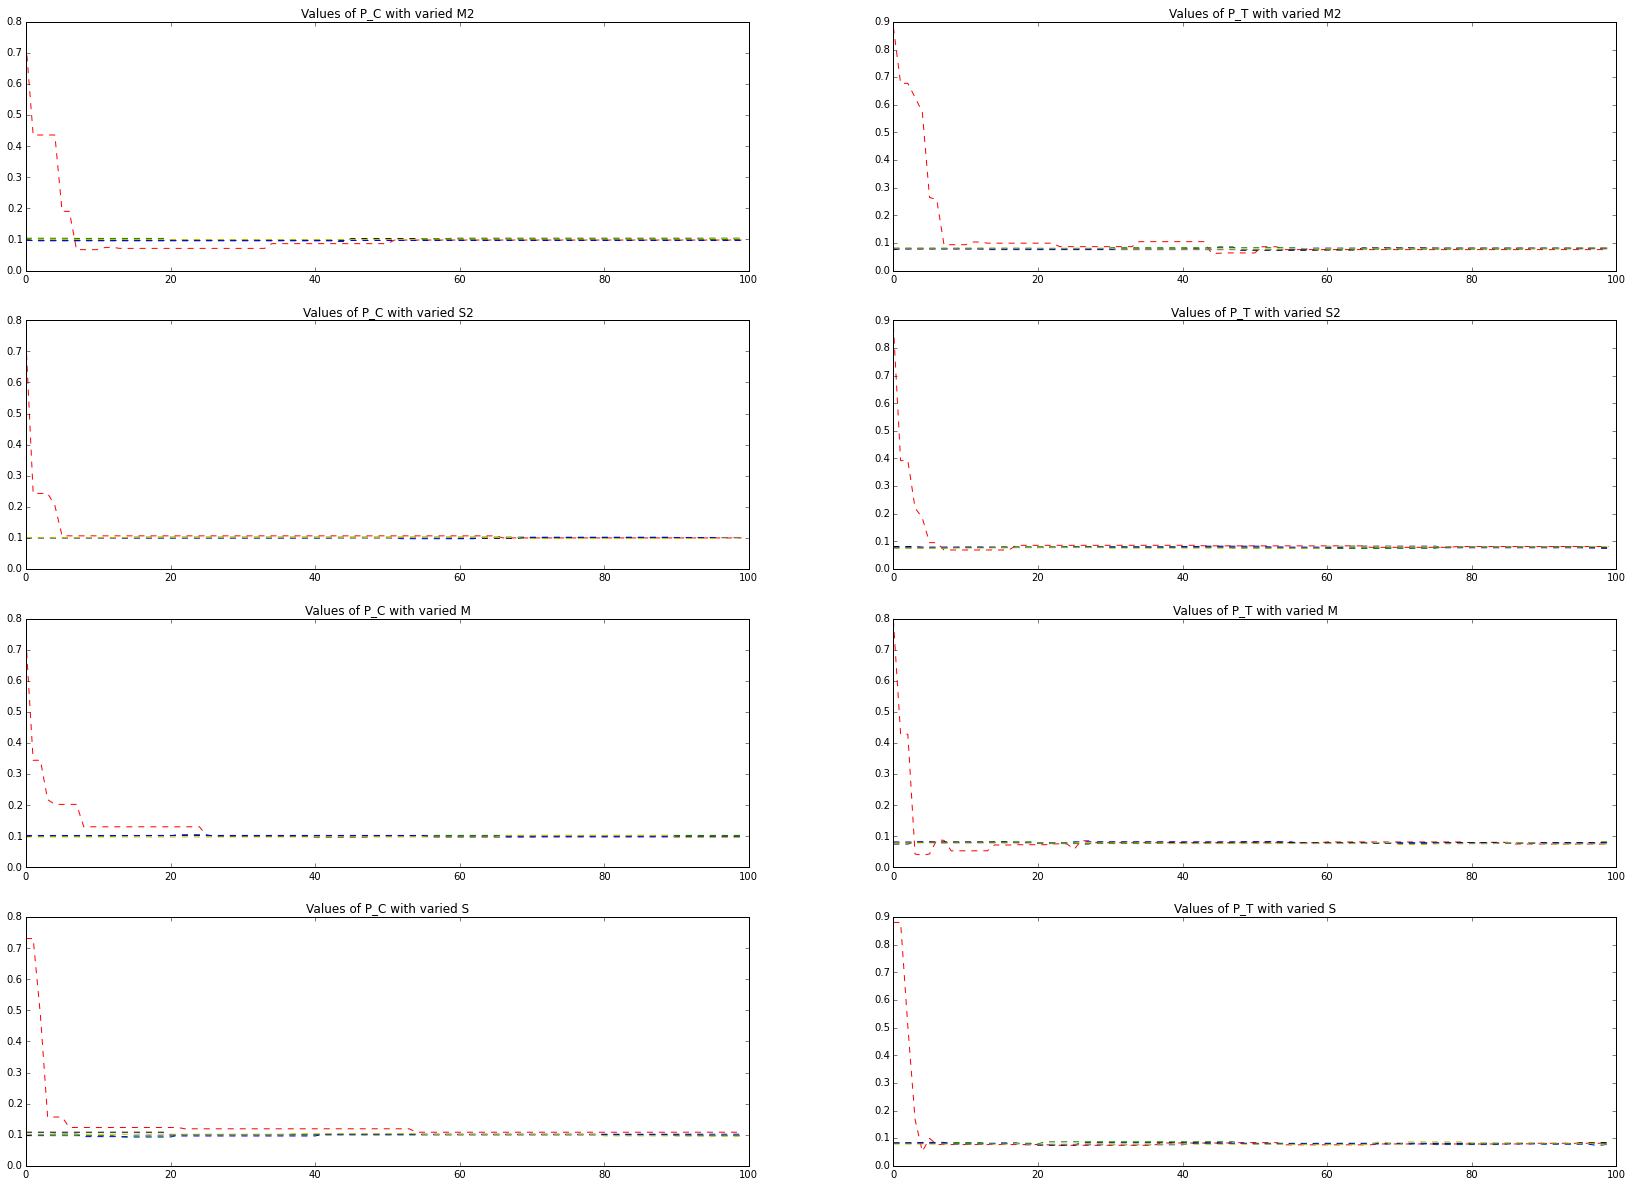

In [11]:
import matplotlib.pyplot as plt

num_samples = 100

fig, ax = plt.subplots()
fig.set_size_inches(28.5, 20.5)

meta = pm.MCMC(meta_analysis2())
meta.m2.set_value(1.)
meta.sample(num_samples)

meta.m2.set_value(2.)
meta.sample(num_samples)

meta.m2.set_value(-1.)
meta.sample(num_samples)

meta.m2.set_value(-2.)
meta.sample(num_samples)

meta.m2.set_value(0.)
meta.sample(num_samples)

plt.subplot(4,2,1)
plt.plot(meta.pc.trace(chain=0), 'r--')
plt.plot(meta.pc.trace(chain=1), 'k--')
plt.plot(meta.pc.trace(chain=2), 'g--')
plt.plot(meta.pc.trace(chain=3), 'b--')
plt.plot(meta.pc.trace(chain=4), 'y--')

plt.title('Values of P_C with varied M2')


plt.subplot(4,2,2)
plt.plot(meta.pt.trace(chain=0), 'r--')
plt.plot(meta.pt.trace(chain=1), 'k--')
plt.plot(meta.pt.trace(chain=2), 'g--')
plt.plot(meta.pt.trace(chain=3), 'b--')
plt.plot(meta.pt.trace(chain=4), 'y--')

plt.title('Values of P_T with varied M2')


meta = pm.MCMC(meta_analysis2())
meta.s2.set_value(1.)
meta.sample(num_samples)

meta.s2.set_value(2.)
meta.sample(num_samples)

meta.s2.set_value(3.)
meta.sample(num_samples)

meta.s2.set_value(4.)
meta.sample(num_samples)

meta.s2.set_value(5.)
meta.sample(num_samples)

plt.subplot(4,2,3)
plt.plot(meta.pc.trace(chain=0), 'r--')
plt.plot(meta.pc.trace(chain=1), 'k--')
plt.plot(meta.pc.trace(chain=2), 'g--')
plt.plot(meta.pc.trace(chain=3), 'b--')
plt.plot(meta.pc.trace(chain=4), 'y--')

plt.title('Values of P_C with varied S2')

plt.subplot(4,2,4)
plt.plot(meta.pt.trace(chain=0), 'r--')
plt.plot(meta.pt.trace(chain=1), 'k--')
plt.plot(meta.pt.trace(chain=2), 'g--')
plt.plot(meta.pt.trace(chain=3), 'b--')
plt.plot(meta.pt.trace(chain=4), 'y--')

plt.title('Values of P_T with varied S2')


meta = pm.MCMC(meta_analysis2())
meta.m.set_value(1.)
meta.sample(num_samples)

meta.m.set_value(2.)
meta.sample(num_samples)

meta.m.set_value(-1.)
meta.sample(num_samples)

meta.m.set_value(-2.)
meta.sample(num_samples)

meta.m.set_value(0.)
meta.sample(num_samples)

plt.subplot(4,2,5)
plt.plot(meta.pc.trace(chain=0), 'r--')
plt.plot(meta.pc.trace(chain=1), 'k--')
plt.plot(meta.pc.trace(chain=2), 'g--')
plt.plot(meta.pc.trace(chain=3), 'b--')
plt.plot(meta.pc.trace(chain=4), 'y--')

plt.title('Values of P_C with varied M')

plt.subplot(4,2,6)
plt.plot(meta.pt.trace(chain=0), 'r--')
plt.plot(meta.pt.trace(chain=1), 'k--')
plt.plot(meta.pt.trace(chain=2), 'g--')
plt.plot(meta.pt.trace(chain=3), 'b--')
plt.plot(meta.pt.trace(chain=4), 'y--')

plt.title('Values of P_T with varied M')

meta = pm.MCMC(meta_analysis2())
meta.s.set_value(1.)
meta.sample(num_samples)

meta.s.set_value(2.)
meta.sample(num_samples)

meta.s.set_value(3.)
meta.sample(num_samples)

meta.s.set_value(4.)
meta.sample(num_samples)

meta.s.set_value(5.)
meta.sample(num_samples)

plt.subplot(4,2,7)
plt.plot(meta.pc.trace(chain=0), 'r--')
plt.plot(meta.pc.trace(chain=1), 'k--')
plt.plot(meta.pc.trace(chain=2), 'g--')
plt.plot(meta.pc.trace(chain=3), 'b--')
plt.plot(meta.pc.trace(chain=4), 'y--')

plt.title('Values of P_C with varied S')

plt.subplot(4,2,8)
plt.plot(meta.pt.trace(chain=0), 'r--')
plt.plot(meta.pt.trace(chain=1), 'k--')
plt.plot(meta.pt.trace(chain=2), 'g--')
plt.plot(meta.pt.trace(chain=3), 'b--')
plt.plot(meta.pt.trace(chain=4), 'y--')

plt.title('Values of P_T with varied S')

 [-----------------100%-----------------] 100 of 100 complete in 0.1 sec

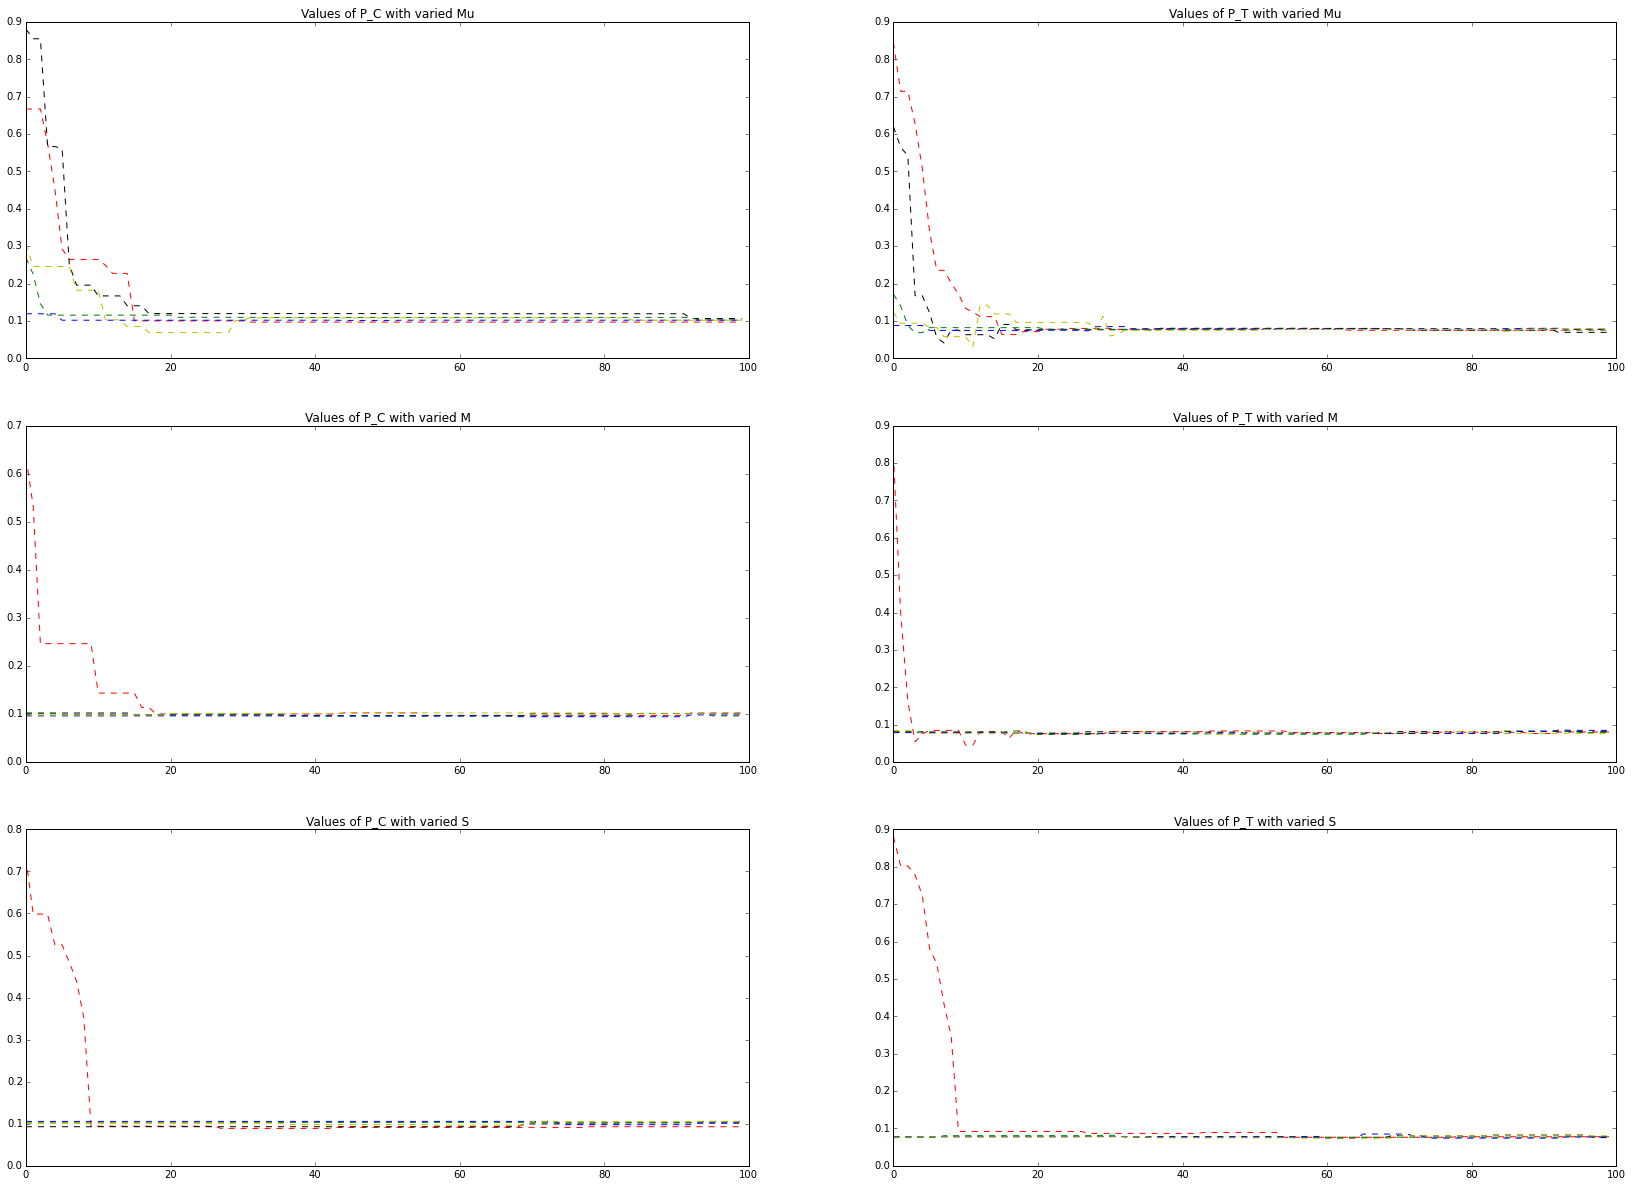

In [12]:
import matplotlib.pyplot as plt

num_samples = 100

fig, ax = plt.subplots()
fig.set_size_inches(28.5, 20.5)

meta = pm.MCMC(meta_analysis3())
meta.mu.set_value(1.)
meta.sample(num_samples)

meta.mu.set_value(2.)
meta.sample(num_samples)

meta.mu.set_value(-1.)
meta.sample(num_samples)

meta.mu.set_value(-2.)
meta.sample(num_samples)

meta.mu.set_value(0.)
meta.sample(num_samples)

plt.subplot(3,2,1)
plt.plot(meta.pc.trace(chain=0), 'r--')
plt.plot(meta.pc.trace(chain=1), 'k--')
plt.plot(meta.pc.trace(chain=2), 'g--')
plt.plot(meta.pc.trace(chain=3), 'b--')
plt.plot(meta.pc.trace(chain=4), 'y--')

plt.title('Values of P_C with varied Mu')


plt.subplot(3,2,2)
plt.plot(meta.pt.trace(chain=0), 'r--')
plt.plot(meta.pt.trace(chain=1), 'k--')
plt.plot(meta.pt.trace(chain=2), 'g--')
plt.plot(meta.pt.trace(chain=3), 'b--')
plt.plot(meta.pt.trace(chain=4), 'y--')

plt.title('Values of P_T with varied Mu')


meta = pm.MCMC(meta_analysis3())
meta.m.set_value(1.)
meta.sample(num_samples)

meta.m.set_value(2.)
meta.sample(num_samples)

meta.m.set_value(-1.)
meta.sample(num_samples)

meta.m.set_value(-2.)
meta.sample(num_samples)

meta.m.set_value(0.)
meta.sample(num_samples)

plt.subplot(3,2,3)
plt.plot(meta.pc.trace(chain=0), 'r--')
plt.plot(meta.pc.trace(chain=1), 'k--')
plt.plot(meta.pc.trace(chain=2), 'g--')
plt.plot(meta.pc.trace(chain=3), 'b--')
plt.plot(meta.pc.trace(chain=4), 'y--')

plt.title('Values of P_C with varied M')

plt.subplot(3,2,4)
plt.plot(meta.pt.trace(chain=0), 'r--')
plt.plot(meta.pt.trace(chain=1), 'k--')
plt.plot(meta.pt.trace(chain=2), 'g--')
plt.plot(meta.pt.trace(chain=3), 'b--')
plt.plot(meta.pt.trace(chain=4), 'y--')

plt.title('Values of P_T with varied M')

meta = pm.MCMC(meta_analysis3())
meta.s.set_value(1.)
meta.sample(num_samples)

meta.s.set_value(2.)
meta.sample(num_samples)

meta.s.set_value(3.)
meta.sample(num_samples)

meta.s.set_value(4.)
meta.sample(num_samples)

meta.s.set_value(5.)
meta.sample(num_samples)

plt.subplot(3,2,5)
plt.plot(meta.pc.trace(chain=0), 'r--')
plt.plot(meta.pc.trace(chain=1), 'k--')
plt.plot(meta.pc.trace(chain=2), 'g--')
plt.plot(meta.pc.trace(chain=3), 'b--')
plt.plot(meta.pc.trace(chain=4), 'y--')

plt.title('Values of P_C with varied S')

plt.subplot(3,2,6)
plt.plot(meta.pt.trace(chain=0), 'r--')
plt.plot(meta.pt.trace(chain=1), 'k--')
plt.plot(meta.pt.trace(chain=2), 'g--')
plt.plot(meta.pt.trace(chain=3), 'b--')
plt.plot(meta.pt.trace(chain=4), 'y--')

plt.title('Values of P_T with varied S')

 [-----------------100%-----------------] 100 of 100 complete in 0.1 sec

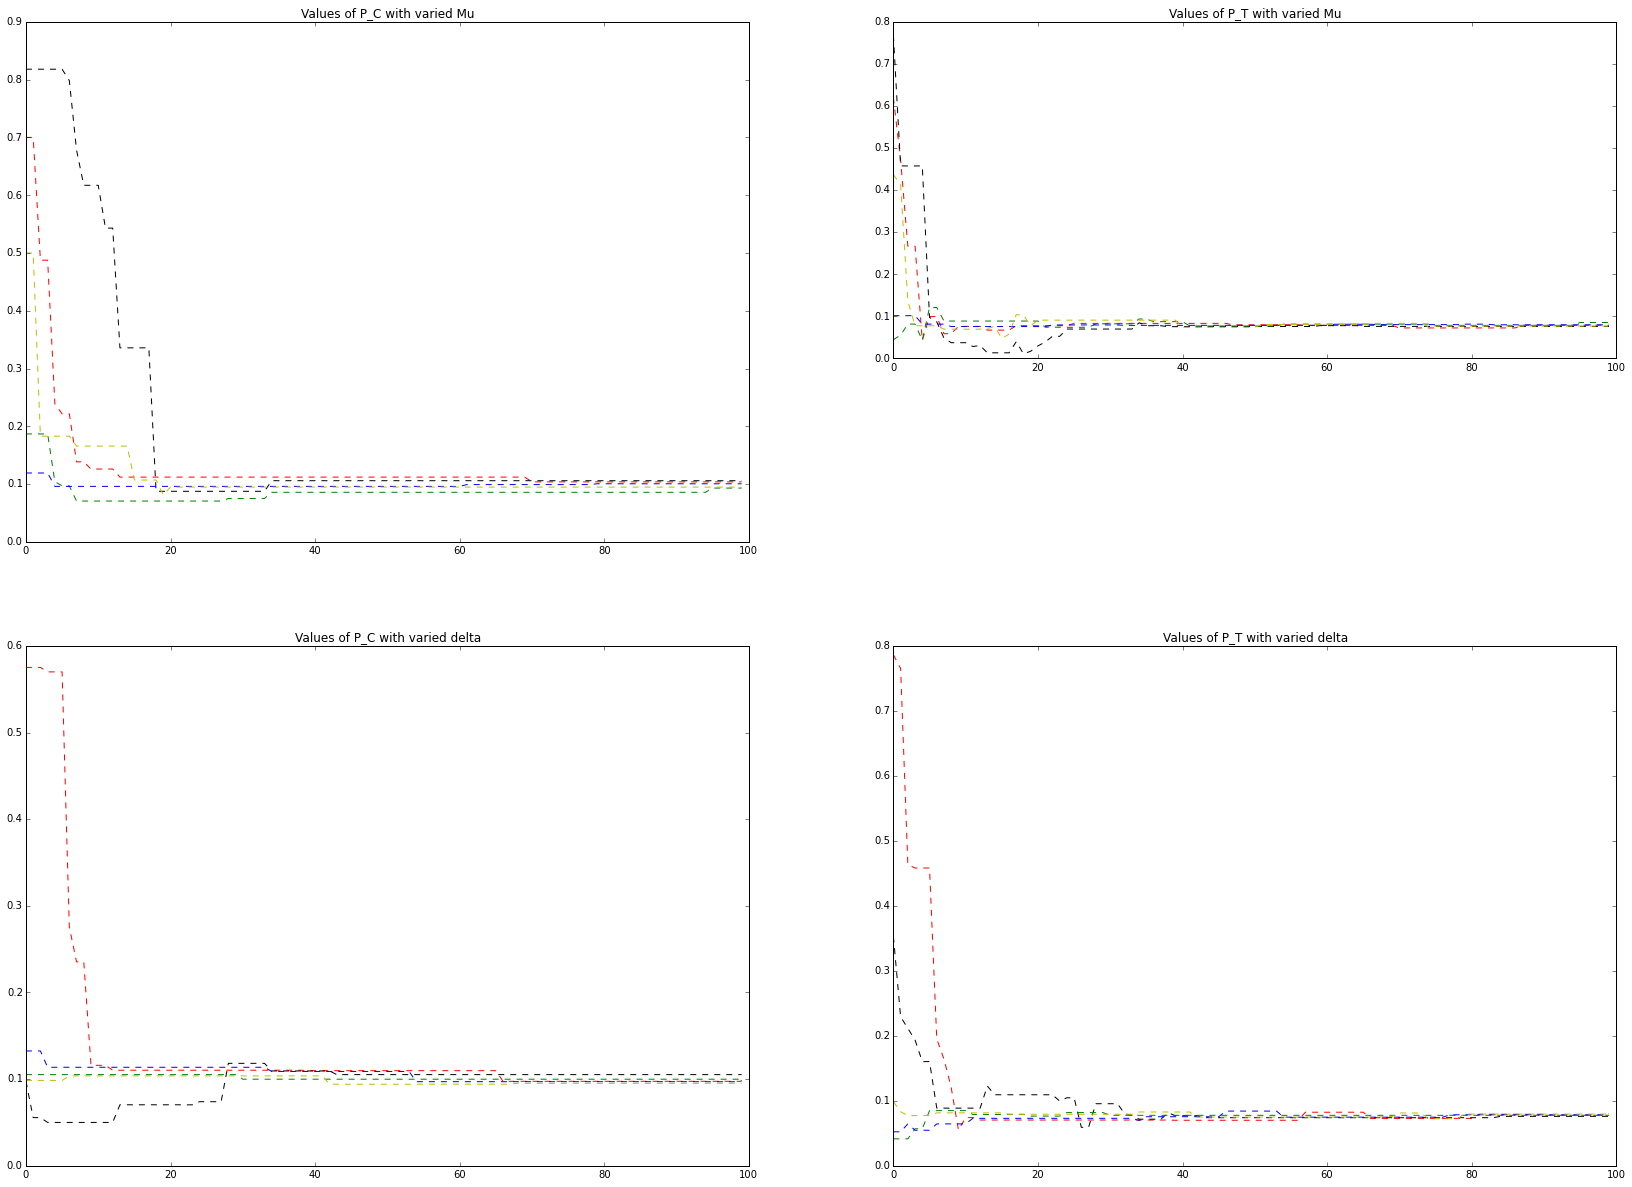

In [13]:
import matplotlib.pyplot as plt

num_samples = 100

fig, ax = plt.subplots()
fig.set_size_inches(28.5, 20.5)

meta = pm.MCMC(meta_analysis4())
meta.mu.set_value(1.)
meta.sample(num_samples)

meta.mu.set_value(2.)
meta.sample(num_samples)

meta.mu.set_value(-1.)
meta.sample(num_samples)

meta.mu.set_value(-2.)
meta.sample(num_samples)

meta.mu.set_value(0.)
meta.sample(num_samples)

plt.subplot(2,2,1)
plt.plot(meta.pc.trace(chain=0), 'r--')
plt.plot(meta.pc.trace(chain=1), 'k--')
plt.plot(meta.pc.trace(chain=2), 'g--')
plt.plot(meta.pc.trace(chain=3), 'b--')
plt.plot(meta.pc.trace(chain=4), 'y--')

plt.title('Values of P_C with varied Mu')


plt.subplot(3,2,2)
plt.plot(meta.pt.trace(chain=0), 'r--')
plt.plot(meta.pt.trace(chain=1), 'k--')
plt.plot(meta.pt.trace(chain=2), 'g--')
plt.plot(meta.pt.trace(chain=3), 'b--')
plt.plot(meta.pt.trace(chain=4), 'y--')

plt.title('Values of P_T with varied Mu')


meta = pm.MCMC(meta_analysis4())
meta.delta.set_value(1.)
meta.sample(num_samples)

meta.delta.set_value(2.)
meta.sample(num_samples)

meta.delta.set_value(-1.)
meta.sample(num_samples)

meta.delta.set_value(-2.)
meta.sample(num_samples)

meta.delta.set_value(0.)
meta.sample(num_samples)

plt.subplot(2,2,3)
plt.plot(meta.pc.trace(chain=0), 'r--')
plt.plot(meta.pc.trace(chain=1), 'k--')
plt.plot(meta.pc.trace(chain=2), 'g--')
plt.plot(meta.pc.trace(chain=3), 'b--')
plt.plot(meta.pc.trace(chain=4), 'y--')

plt.title('Values of P_C with varied delta')

plt.subplot(2,2,4)
plt.plot(meta.pt.trace(chain=0), 'r--')
plt.plot(meta.pt.trace(chain=1), 'k--')
plt.plot(meta.pt.trace(chain=2), 'g--')
plt.plot(meta.pt.trace(chain=3), 'b--')
plt.plot(meta.pt.trace(chain=4), 'y--')

plt.title('Values of P_T with varied delta')

In all of the cases the model ended up at the same basic spot with respect to the model choice. In some cases the model converged faster than others but in all cases the same basic effect was seen.

In [14]:
meta1 = pm.MCMC(meta_analysis1())
meta2 = pm.MCMC(meta_analysis2())
meta3 = pm.MCMC(meta_analysis3())
meta4 = pm.MCMC(meta_analysis4())

num_samples = 10000
burn = 5000
meta1.sample(num_samples,burn)
meta2.sample(num_samples,burn)
meta3.sample(num_samples,burn)
meta4.sample(num_samples,burn)
print()
print('Meta1: %s' % meta1.DIC)
print('Meta2: %s' % meta2.DIC)
print('Meta3: %s' % meta3.DIC)
print('Meta4: %s' % meta4.DIC)

 [-----------------100%-----------------] 10000 of 10000 complete in 9.8 sec
Meta1: 526.961282956
Meta2: 526.929110227
Meta3: 526.876039135
Meta4: 527.985775144


It looks like this model doesn't really create different results based on deviance information criteria. This leads me to believe that the choice of fixed or random effect does not make a difference within this model situation so the model with both fixed effects proves most accurate.

## Question 3


The `titanic.xls` spreadsheet in the `data` directory contains data regarding the passengers on the Titanic when it sank in 1912. A recent [Kaggle competition](http://www.kaggle.com/c/titanic-gettingStarted) was based on predicting survival for passengers based on the attributes in the passenger list. 

Use scikit-learn to build both a support vector classifier and a logistic regression model to predict survival on the Titanic. Use cross-validation to assess your models, and try to tune them to improve performance.

Discuss the benefits and drawbacks of both approaches for application to such problems.

In [15]:
# Write your work here